In [ ]:
!pip install tensorflow

In [2]:
import cv2
import os
import random
import tensorflow as tf
from shutil import copyfile
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array, load_img
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
data_dirs = ['Tomato_YellowLeaf_Curl_Virus', 'Tomato_healthy', 'Tomato_Septoria_leaf_spot']
source_path = "/content/gdrive/MyDrive/Colab Notebooks/dataset/"

DATA_CLASSES = ['Tomato_YellowLeaf_Curl_Virus', 'Tomato_healthy', 'Tomato_Septoria_leaf_spot']

for i, dir in enumerate(data_dirs):
    class_dir = os.path.join(source_path, dir)
    print(f'There are {len(os.listdir(class_dir))} images of {DATA_CLASSES[i]}')

There are 3209 images of Tomato_YellowLeaf_Curl_Virus
There are 1591 images of Tomato_healthy
There are 1771 images of Tomato_Septoria_leaf_spot


# Бинарный классификатор

## Создадим папки для тренировочных, валидационных, и тестированных данных

In [51]:
root_binary = 'binary_data'

train_dir = os.path.join(root_binary, 'train')
if not os.path.exists(train_dir):
    os.makedirs(os.path.join(root_binary, 'train'))

# Создание директории "validation", если она не существует
validation_dir = os.path.join(root_binary, 'validation')
if not os.path.exists(validation_dir):
    os.makedirs(os.path.join(root_binary, 'validation'))

# Создание директории "testing", если она не существует
testing_dir = os.path.join(root_binary, 'testing')
if not os.path.exists(testing_dir):
    os.makedirs(os.path.join(root_binary, 'testing'))

os.makedirs(os.path.join(root_binary, 'train/tomato_virus'))
os.makedirs(os.path.join(root_binary, 'train/tomato_healthy'))

os.makedirs(os.path.join(root_binary, 'validation/tomato_virus'))
os.makedirs(os.path.join(root_binary, 'validation/tomato_healthy'))

os.makedirs(os.path.join(root_binary, 'testing/tomato_virus'))
os.makedirs(os.path.join(root_binary, 'testing/tomato_healthy'))

In [52]:
!ls binary_data/validation

tomato_healthy	tomato_virus


## Разделим данные на тренировки, валидации, и тестирования

In [53]:
def split_data(SOURCE, TRAINING, VALIDATION, TESTING, TRAINING_SPLIT, VALIDATION_SPLIT, TESTING_SPLIT):
    filtered_files = []

    for file_name in os.listdir(SOURCE):
        file_path = os.path.join(SOURCE, file_name)

        if os.path.getsize(file_path):
            filtered_files.append(file_name)
        else:
            print('{} is zero length, so ignoring.'.format(file_name))

    # Split the files
    random_files = random.sample(filtered_files, len(filtered_files))
    split_train = int(TRAINING_SPLIT * len(filtered_files))
    split_val = split_train + int(VALIDATION_SPLIT * len(filtered_files))
    split_test = split_val + int(TESTING_SPLIT * len(filtered_files))

    training_files = random_files[:split_train]
    val_files = random_files[split_train:split_val]
    test_files = random_files[split_val:]

    # Copy the files
    for file_name in training_files:
        copyfile(os.path.join(SOURCE, file_name), os.path.join(TRAINING, file_name))

    for file_name in val_files:
        copyfile(os.path.join(SOURCE, file_name), os.path.join(VALIDATION, file_name))

    for file_name in test_files:
        copyfile(os.path.join(SOURCE, file_name), os.path.join(TESTING, file_name))

In [54]:
TOMATO_VIRUS_DIR = source_path + data_dirs[0]
TOMATO_HEALTHY_DIR = source_path + data_dirs[1]

TRAINING_DIR = "binary_data/train/"
VAL_DIR = "binary_data/validation/"
TEST_DIR = "binary_data/testing/"

TRAINING_TOMATO_VIRUS_DIR = os.path.join(TRAINING_DIR, "tomato_virus/")
VAL_TOMATO_VIRUS_DIR = os.path.join(VAL_DIR, "tomato_virus/")
TEST_TOMATO_VIRUS_DIR = os.path.join(TEST_DIR, "tomato_virus/")

TRAINING_TOMATO_HEALTHY_DIR = os.path.join(TRAINING_DIR, "tomato_healthy/")
VAL_TOMATO_HEALTHY_DIR = os.path.join(VAL_DIR, "tomato_healthy/")
TEST_TOMATO_HEALTHY_DIR = os.path.join(TEST_DIR, "tomato_healthy/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_TOMATO_VIRUS_DIR)) > 0:
    for file in os.scandir(TRAINING_TOMATO_VIRUS_DIR):
        os.remove(file.path)
if len(os.listdir(TRAINING_TOMATO_HEALTHY_DIR)) > 0:
    for file in os.scandir(TRAINING_TOMATO_HEALTHY_DIR):
        os.remove(file.path)

if len(os.listdir(VAL_TOMATO_VIRUS_DIR)) > 0:
    for file in os.scandir(VAL_TOMATO_VIRUS_DIR):
        os.remove(file.path)
if len(os.listdir(VAL_TOMATO_HEALTHY_DIR)) > 0:
    for file in os.scandir(VAL_TOMATO_HEALTHY_DIR):
        os.remove(file.path)

if len(os.listdir(TEST_TOMATO_VIRUS_DIR)) > 0:
    for file in os.scandir(TEST_TOMATO_VIRUS_DIR):
        os.remove(file.path)
if len(os.listdir(TEST_TOMATO_HEALTHY_DIR)) > 0:
    for file in os.scandir(TEST_TOMATO_HEALTHY_DIR):
        os.remove(file.path)


# Define proportion of images used for training
split_train_size = .7
split_val_size = .2
split_test_size = .1

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(TOMATO_VIRUS_DIR, TRAINING_TOMATO_VIRUS_DIR, VAL_TOMATO_VIRUS_DIR, TEST_TOMATO_VIRUS_DIR,
           split_train_size, split_val_size, split_test_size)
split_data(TOMATO_HEALTHY_DIR, TRAINING_TOMATO_HEALTHY_DIR, VAL_TOMATO_HEALTHY_DIR, TEST_TOMATO_HEALTHY_DIR,
           split_train_size, split_val_size, split_test_size)


# Check that the number of images matches the expected output
print(f"There are {len(os.listdir(TRAINING_TOMATO_VIRUS_DIR))} images of {DATA_CLASSES[0]} for training")
print(f"There are {len(os.listdir(TRAINING_TOMATO_HEALTHY_DIR))} images of {DATA_CLASSES[1]} for training")

print(f"\nThere are {len(os.listdir(VAL_TOMATO_VIRUS_DIR))} images of {DATA_CLASSES[0]} for validation")
print(f"There are {len(os.listdir(VAL_TOMATO_HEALTHY_DIR))} images of {DATA_CLASSES[1]} for validation")

print(f"\nThere are {len(os.listdir(TEST_TOMATO_VIRUS_DIR))} images of {DATA_CLASSES[0]} for testing")
print(f"There are {len(os.listdir(TEST_TOMATO_HEALTHY_DIR))} images of {DATA_CLASSES[1]} for testing")

svn-r6Yb5c is zero length, so ignoring.
There are 2245 images of Tomato_YellowLeaf_Curl_Virus for training
There are 1113 images of Tomato_healthy for training

There are 641 images of Tomato_YellowLeaf_Curl_Virus for validation
There are 318 images of Tomato_healthy for validation

There are 322 images of Tomato_YellowLeaf_Curl_Virus for testing
There are 160 images of Tomato_healthy for testing


## Генерации данных для классификации

In [55]:
def train_val_testing_generators(TRAINING_DIR, VALIDATION_DIR, TESTING_DIR):
    # Instantiate the ImageDataGenerator class
    train_datagen = ImageDataGenerator(rescale = 1.0 / 255.,
                                     rotation_range = 40,
                                     width_shift_range = .2,
                                     height_shift_range = .2,
                                     shear_range = .2,
                                     zoom_range = .2,
                                     horizontal_flip = True,
                                     fill_mode = 'nearest')

    # Pass in the appropriate arguments to the flow_from_directory method
    train_generator = train_datagen.flow_from_directory(directory = TRAINING_DIR,
                                                      batch_size = 64,
                                                      class_mode = 'categorical',
                                                      target_size = (256, 256))

    # Instantiate the ImageDataGenerator class
    validation_datagen = ImageDataGenerator(rescale = 1.0 / 255.,
                                          rotation_range = 40,
                                          width_shift_range = .2,
                                          height_shift_range = .2,
                                          shear_range = .2,
                                          zoom_range = .2,
                                          horizontal_flip = True,
                                          fill_mode = 'nearest')

    # Pass in the appropriate arguments to the flow_from_directory method
    validation_generator = validation_datagen.flow_from_directory(directory = VALIDATION_DIR,
                                                                batch_size = 64,
                                                                class_mode = 'categorical',
                                                                target_size = (256, 256))

    # Instantiate the ImageDataGenerator class
    testing_datagen = ImageDataGenerator(rescale = 1.0 / 255.,
                                          rotation_range = 40,
                                          width_shift_range = .2,
                                          height_shift_range = .2,
                                          shear_range = .2,
                                          zoom_range = .2,
                                          horizontal_flip = True,
                                          fill_mode = 'nearest')

    # Pass in the appropriate arguments to the flow_from_directory method
    testing_generator = testing_datagen.flow_from_directory(directory = TESTING_DIR,
                                                                batch_size = 64,
                                                                class_mode = 'categorical',
                                                                target_size = (256, 256))


    return train_generator, validation_generator, testing_generator

In [56]:
# Test your generators
train_generator, validation_generator, testing_generator = train_val_testing_generators(TRAINING_DIR, VAL_DIR, TEST_DIR)

Found 3358 images belonging to 2 classes.
Found 959 images belonging to 2 classes.
Found 482 images belonging to 2 classes.


## Построим модель

In [57]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [58]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 30, 30, 128)      

In [59]:
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Тренировать модель

In [60]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    verbose=1
)

Epoch 1/10
53/53 [==============================] - 85s 2s/step - loss: 0.3025 - accuracy: 0.8621 - val_loss: 0.1521 - val_accuracy: 0.9406
Epoch 2/10
53/53 [==============================] - 82s 2s/step - loss: 0.0900 - accuracy: 0.9750 - val_loss: 0.1595 - val_accuracy: 0.9364
Epoch 3/10
53/53 [==============================] - 82s 2s/step - loss: 0.0577 - accuracy: 0.9824 - val_loss: 0.0496 - val_accuracy: 0.9917
Epoch 4/10
53/53 [==============================] - 86s 2s/step - loss: 0.0451 - accuracy: 0.9896 - val_loss: 0.0152 - val_accuracy: 0.9937
Epoch 5/10
53/53 [==============================] - 82s 2s/step - loss: 0.0332 - accuracy: 0.9923 - val_loss: 0.0087 - val_accuracy: 0.9990
Epoch 6/10
53/53 [==============================] - 82s 2s/step - loss: 0.0448 - accuracy: 0.9845 - val_loss: 0.0059 - val_accuracy: 0.9990
Epoch 7/10
53/53 [==============================] - 83s 2s/step - loss: 0.0107 - accuracy: 0.9973 - val_loss: 0.0042 - val_accuracy: 0.9979
Epoch 8/10
53/53 [==

## Plot Performance

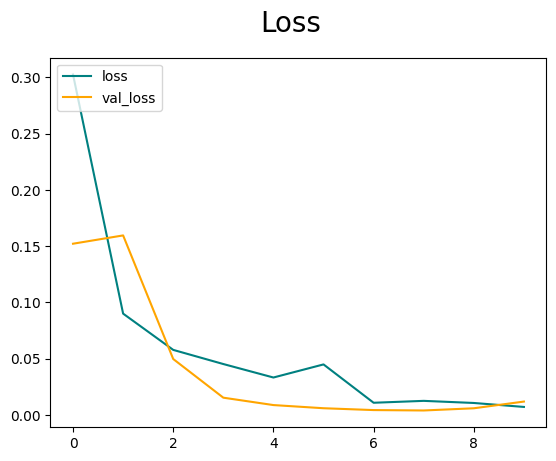

In [61]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

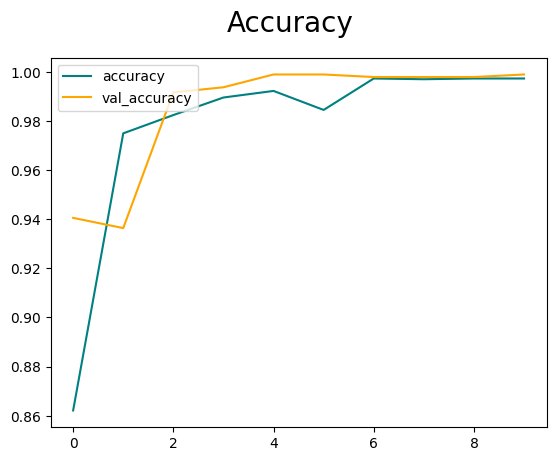

In [62]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

## Evaluate with test data

In [20]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [48]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [49]:
final_predictions = model.predict(testing_generator)

8/8 [==============================] - 29s 3s/step


In [50]:
true_labels = np.squeeze(testing_generator.classes)

In [51]:
binary_preds = np.argmax(final_predictions, axis=1)

In [52]:
pre.update_state(true_labels, binary_preds)
re.update_state(true_labels, binary_preds)
acc.update_state(true_labels, binary_preds)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=482.0>

In [53]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.6635220050811768, Recall: 0.6552795171737671, Accuracy: 0.5477178692817688


Получились не слишком хорошие характеристики, скорее всего из-за неравномерности датасета

In [8]:
# Function to load and preprocess an image for prediction
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(256, 256))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

In [65]:
# Path to the image you want to predict
image_path0 = '/content/gdrive/MyDrive/Colab Notebooks/dataset/Tomato_YellowLeaf_Curl_Virus/0e70ed92-83e0-42ee-bb0e-24a2063db86f___UF.GRC_YLCV_Lab 01659.JPG'
image_path1 = '/content/gdrive/MyDrive/Colab Notebooks/dataset/Tomato_healthy/4f5dde42-a6ac-4886-8b9e-a944568ace95___RS_HL 0080.JPG'

1/1 [==============================] - 0s 53ms/step


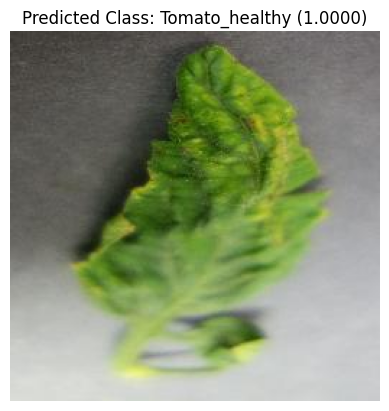

In [68]:
loaded_image = image_path0

# Load and preprocess the image
input_image = load_and_preprocess_image(loaded_image)

# Make a prediction
predictions = model.predict(input_image)

# Decode the predictions
predicted_class_index = np.argmax(predictions)
predicted_class_label = DATA_CLASSES[predicted_class_index]
predicted_probability = predictions[0][predicted_class_index]

# Display the image
img = mpimg.imread(loaded_image)
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted Class: {predicted_class_label} ({predicted_probability:.4f})')
plt.show()

1/1 [==============================] - 0s 52ms/step


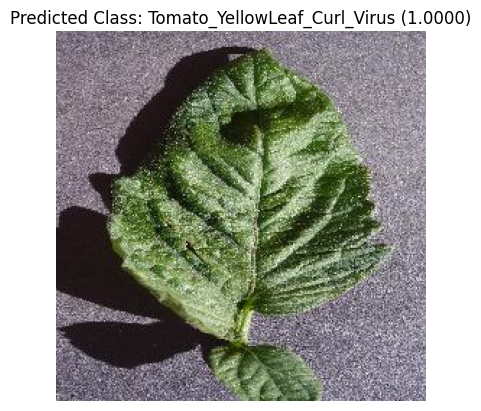

In [60]:
loaded_image = image_path1

# Load and preprocess the image
input_image = load_and_preprocess_image(loaded_image)

# Make a prediction
predictions = model.predict(input_image)

# Decode the predictions
predicted_class_index = np.argmax(predictions)
predicted_class_label = DATA_CLASSES[predicted_class_index]
predicted_probability = predictions[0][predicted_class_index]

# Display the image
img = mpimg.imread(loaded_image)
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted Class: {predicted_class_label} ({predicted_probability:.4f})')
plt.show()

Модель выдает противоположные результаты

# Многоклассовый классификатор

## Model A (Without pre-trained model)

### Создадим папку

In [9]:
root_binary = 'multi_class'

os.makedirs(os.path.join(root_binary, 'train'))
os.makedirs(os.path.join(root_binary, 'validation'))
os.makedirs(os.path.join(root_binary, 'testing'))

os.makedirs(os.path.join(root_binary, 'train/tomato_virus'))
os.makedirs(os.path.join(root_binary, 'train/tomato_healthy'))
os.makedirs(os.path.join(root_binary, 'train/tomato_spot'))

os.makedirs(os.path.join(root_binary, 'validation/tomato_virus'))
os.makedirs(os.path.join(root_binary, 'validation/tomato_healthy'))
os.makedirs(os.path.join(root_binary, 'validation/tomato_spot'))

os.makedirs(os.path.join(root_binary, 'testing/tomato_virus'))
os.makedirs(os.path.join(root_binary, 'testing/tomato_healthy'))
os.makedirs(os.path.join(root_binary, 'testing/tomato_spot'))

### Разделим данных на данные для обучения, валидации, и тестирования

In [10]:
TOMATO_VIRUS_DIR = source_path + data_dirs[0]
TOMATO_HEALTHY_DIR = source_path + data_dirs[1]
TOMATO_SPOT_DIR = source_path + data_dirs[2]

TRAINING_DIR = "multi_class/train/"
VAL_DIR = "multi_class/validation/"
TEST_DIR = "multi_class/testing/"

TRAINING_TOMATO_VIRUS_DIR = os.path.join(TRAINING_DIR, "tomato_virus/")
VAL_TOMATO_VIRUS_DIR = os.path.join(VAL_DIR, "tomato_virus/")
TEST_TOMATO_VIRUS_DIR = os.path.join(TEST_DIR, "tomato_virus/")

TRAINING_TOMATO_HEALTHY_DIR = os.path.join(TRAINING_DIR, "tomato_healthy/")
VAL_TOMATO_HEALTHY_DIR = os.path.join(VAL_DIR, "tomato_healthy/")
TEST_TOMATO_HEALTHY_DIR = os.path.join(TEST_DIR, "tomato_healthy/")

TRAINING_TOMATO_SPOT_DIR = os.path.join(TRAINING_DIR, "tomato_spot/")
VAL_TOMATO_SPOT_DIR = os.path.join(VAL_DIR, "tomato_spot/")
TEST_TOMATO_SPOT_DIR = os.path.join(TEST_DIR, "tomato_spot/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_TOMATO_VIRUS_DIR)) > 0:
    for file in os.scandir(TRAINING_TOMATO_VIRUS_DIR):
        os.remove(file.path)
if len(os.listdir(TRAINING_TOMATO_HEALTHY_DIR)) > 0:
    for file in os.scandir(TRAINING_TOMATO_HEALTHY_DIR):
        os.remove(file.path)
if len(os.listdir(TRAINING_TOMATO_SPOT_DIR)) > 0:
    for file in os.scandir(TRAINING_TOMATO_SPOT_DIR):
        os.remove(file.path)

if len(os.listdir(VAL_TOMATO_VIRUS_DIR)) > 0:
    for file in os.scandir(VAL_TOMATO_VIRUS_DIR):
        os.remove(file.path)
if len(os.listdir(VAL_TOMATO_HEALTHY_DIR)) > 0:
    for file in os.scandir(VAL_TOMATO_HEALTHY_DIR):
        os.remove(file.path)
if len(os.listdir(VAL_TOMATO_SPOT_DIR)) > 0:
    for file in os.scandir(VAL_TOMATO_SPOT_DIR):
        os.remove(file.path)

if len(os.listdir(TEST_TOMATO_VIRUS_DIR)) > 0:
    for file in os.scandir(TEST_TOMATO_VIRUS_DIR):
        os.remove(file.path)
if len(os.listdir(TEST_TOMATO_HEALTHY_DIR)) > 0:
    for file in os.scandir(TEST_TOMATO_HEALTHY_DIR):
        os.remove(file.path)
if len(os.listdir(TEST_TOMATO_SPOT_DIR)) > 0:
    for file in os.scandir(TEST_TOMATO_SPOT_DIR):
        os.remove(file.path)



# Define proportion of images used for training
split_train_size = .75
split_val_size = .2
split_test_size = .05

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(TOMATO_VIRUS_DIR, TRAINING_TOMATO_VIRUS_DIR, VAL_TOMATO_VIRUS_DIR, TEST_TOMATO_VIRUS_DIR,
           split_train_size, split_val_size, split_test_size)
split_data(TOMATO_HEALTHY_DIR, TRAINING_TOMATO_HEALTHY_DIR, VAL_TOMATO_HEALTHY_DIR, TEST_TOMATO_HEALTHY_DIR,
           split_train_size, split_val_size, split_test_size)
split_data(TOMATO_SPOT_DIR, TRAINING_TOMATO_SPOT_DIR, VAL_TOMATO_SPOT_DIR, TEST_TOMATO_SPOT_DIR,
           split_train_size, split_val_size, split_test_size)


# Check that the number of images matches the expected output
print(f"There are {len(os.listdir(TRAINING_TOMATO_VIRUS_DIR))} images of {DATA_CLASSES[0]} for training")
print(f"There are {len(os.listdir(TRAINING_TOMATO_HEALTHY_DIR))} images of {DATA_CLASSES[1]} for training")
print(f"There are {len(os.listdir(TRAINING_TOMATO_SPOT_DIR))} images of {DATA_CLASSES[2]} for training")

print(f"\nThere are {len(os.listdir(VAL_TOMATO_VIRUS_DIR))} images of {DATA_CLASSES[0]} for validation")
print(f"There are {len(os.listdir(VAL_TOMATO_HEALTHY_DIR))} images of {DATA_CLASSES[1]} for validation")
print(f"There are {len(os.listdir(VAL_TOMATO_SPOT_DIR))} images of {DATA_CLASSES[2]} for validation")

print(f"\nThere are {len(os.listdir(TEST_TOMATO_VIRUS_DIR))} images of {DATA_CLASSES[0]} for testing")
print(f"There are {len(os.listdir(TEST_TOMATO_HEALTHY_DIR))} images of {DATA_CLASSES[1]} for testing")
print(f"There are {len(os.listdir(TEST_TOMATO_SPOT_DIR))} images of {DATA_CLASSES[2]} for testing")

svn-r6Yb5c is zero length, so ignoring.
There are 2406 images of Tomato_YellowLeaf_Curl_Virus for training
There are 1193 images of Tomato_healthy for training
There are 1328 images of Tomato_Septoria_leaf_spot for training

There are 641 images of Tomato_YellowLeaf_Curl_Virus for validation
There are 318 images of Tomato_healthy for validation
There are 354 images of Tomato_Septoria_leaf_spot for validation

There are 161 images of Tomato_YellowLeaf_Curl_Virus for testing
There are 80 images of Tomato_healthy for testing
There are 89 images of Tomato_Septoria_leaf_spot for testing


### Генерирование этих данных

In [11]:
# Test your generators
train_generator, validation_generator, testing_generator = train_val_testing_generators(TRAINING_DIR, VAL_DIR, TEST_DIR)

Found 4927 images belonging to 3 classes.
Found 1313 images belonging to 3 classes.
Found 330 images belonging to 3 classes.


### Построить модель

In [12]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

In [14]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Тренировки модели

In [15]:
history = model.fit(
    train_generator,batch_size=32,
    epochs=15,
    validation_data=validation_generator,
    verbose=1
)

Epoch 1/15
77/77 [==============================] - 141s 2s/step - loss: 0.6621 - accuracy: 0.7104 - val_loss: 0.3408 - val_accuracy: 0.8629
Epoch 2/15
77/77 [==============================] - 127s 2s/step - loss: 0.3960 - accuracy: 0.8494 - val_loss: 0.3538 - val_accuracy: 0.8682
Epoch 3/15
77/77 [==============================] - 141s 2s/step - loss: 0.2134 - accuracy: 0.9247 - val_loss: 0.1645 - val_accuracy: 0.9596
Epoch 4/15
77/77 [==============================] - 121s 2s/step - loss: 0.1578 - accuracy: 0.9468 - val_loss: 0.1917 - val_accuracy: 0.9345
Epoch 5/15
77/77 [==============================] - 122s 2s/step - loss: 0.1609 - accuracy: 0.9442 - val_loss: 0.1138 - val_accuracy: 0.9650
Epoch 6/15
77/77 [==============================] - 124s 2s/step - loss: 0.0728 - accuracy: 0.9748 - val_loss: 0.0486 - val_accuracy: 0.9893
Epoch 7/15
77/77 [==============================] - 139s 2s/step - loss: 0.1135 - accuracy: 0.9612 - val_loss: 0.0840 - val_accuracy: 0.9733
Epoch 8/15
77

### Plot performance

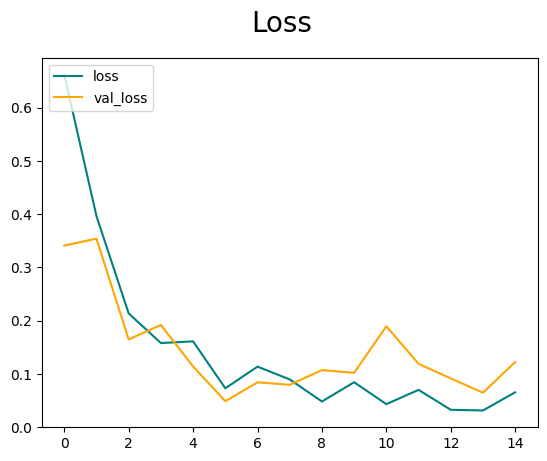

In [16]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

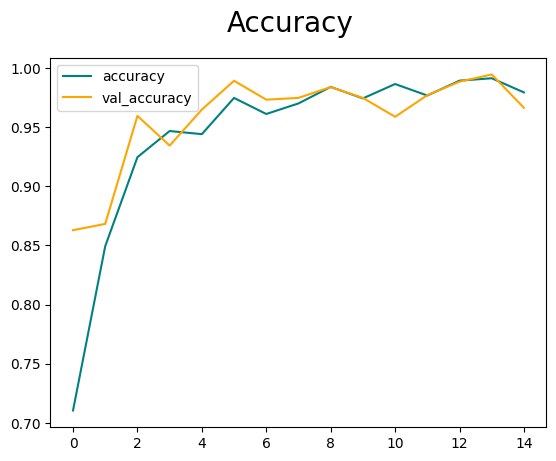

In [17]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

### Evaluate with test data

In [21]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [22]:
final_predictions = model.predict(testing_generator)

6/6 [==============================] - 6s 852ms/step


In [23]:
true_labels = np.squeeze(testing_generator.classes)

In [24]:
binary_preds = np.argmax(final_predictions, axis=1)

In [25]:
pre.update_state(true_labels, binary_preds)
re.update_state(true_labels, binary_preds)
acc.update_state(true_labels, binary_preds)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=330.0>

In [26]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.7627118825912476, Recall: 0.7200000286102295, Accuracy: 0.269696980714798


Точность получилась плохая

### Evaluate with some data

In [27]:
# Path to the image you want to predict
image_path0 = '/content/gdrive/MyDrive/Colab Notebooks/dataset/Tomato_YellowLeaf_Curl_Virus/16cdaa11-8d94-43ff-9acc-14048ad8f77f___UF.GRC_YLCV_Lab 02178.JPG'
image_path1 = '/content/gdrive/MyDrive/Colab Notebooks/dataset/Tomato_healthy/45b3e6ad-f79c-4132-9bb5-9e9d26cbdfce___RS_HL 9908.JPG'
image_path2 = '/content/gdrive/MyDrive/Colab Notebooks/dataset/Tomato_Septoria_leaf_spot/3fc4d8fe-a68b-4d84-b987-be97052f0436___Matt.S_CG 6570.JPG'

1/1 [==============================] - 0s 20ms/step


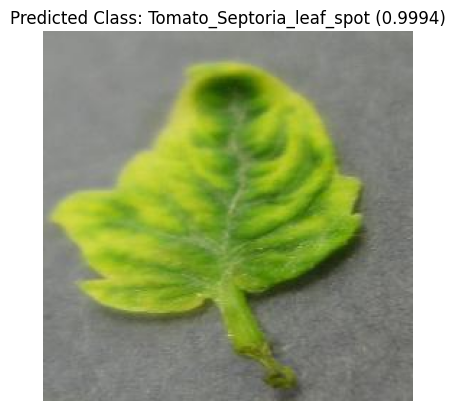

In [32]:
loaded_image = image_path0

# Load and preprocess the image
input_image = load_and_preprocess_image(loaded_image)

# Make a prediction
predictions = model.predict(input_image)

# Decode the predictions
predicted_class_index = np.argmax(predictions)
predicted_class_label = DATA_CLASSES[predicted_class_index]
predicted_probability = predictions[0][predicted_class_index]

# Display the image
img = mpimg.imread(loaded_image)
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted Class: {predicted_class_label} ({predicted_probability:.4f})')
plt.show()

1/1 [==============================] - 0s 52ms/step


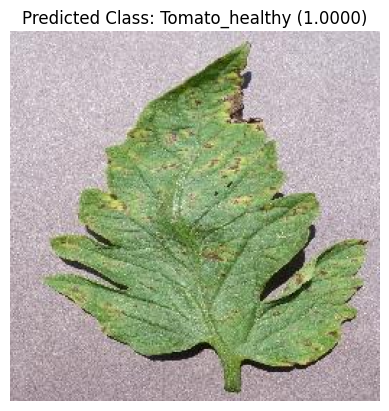

In [33]:
loaded_image = image_path2

# Load and preprocess the image
input_image = load_and_preprocess_image(loaded_image)

# Make a prediction
predictions = model.predict(input_image)

# Decode the predictions
predicted_class_index = np.argmax(predictions)
predicted_class_label = DATA_CLASSES[predicted_class_index]
predicted_probability = predictions[0][predicted_class_index]

# Display the image
img = mpimg.imread(loaded_image)
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted Class: {predicted_class_label} ({predicted_probability:.4f})')
plt.show()

## Модель B (with pre-trained model)

In [34]:
from tensorflow.keras.applications import ResNet50

In [35]:
# Load the pre-trained ResNet50 model without the top (fully connected) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the pre-trained layers so that they are not trainable
for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 3s 0us/step


In [36]:
# Test your generators
train_generator, validation_generator, testing_generator = train_val_testing_generators(TRAINING_DIR, VAL_DIR, TEST_DIR)

Found 4927 images belonging to 3 classes.
Found 1313 images belonging to 3 classes.
Found 330 images belonging to 3 classes.


In [37]:
# Make the model
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense_2 (Dense)             (None, 512)               67109376  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 90698627 (345.99 MB)
Trainable params: 67110915 (256.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [39]:
# Compile the model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [40]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    verbose=1
)

Epoch 1/10
77/77 [==============================] - 143s 2s/step - loss: 5.9224 - accuracy: 0.4611 - val_loss: 0.9444 - val_accuracy: 0.6184
Epoch 2/10
77/77 [==============================] - 131s 2s/step - loss: 0.9709 - accuracy: 0.5573 - val_loss: 0.8912 - val_accuracy: 0.6222
Epoch 3/10
77/77 [==============================] - 131s 2s/step - loss: 0.9359 - accuracy: 0.5760 - val_loss: 0.8015 - val_accuracy: 0.6245
Epoch 4/10
77/77 [==============================] - 144s 2s/step - loss: 0.9191 - accuracy: 0.5847 - val_loss: 0.7601 - val_accuracy: 0.6299
Epoch 5/10
77/77 [==============================] - 146s 2s/step - loss: 0.8742 - accuracy: 0.5862 - val_loss: 0.7338 - val_accuracy: 0.6291
Epoch 6/10
77/77 [==============================] - 157s 2s/step - loss: 0.9392 - accuracy: 0.5870 - val_loss: 0.7497 - val_accuracy: 0.6321
Epoch 7/10
77/77 [==============================] - 147s 2s/step - loss: 0.8625 - accuracy: 0.5957 - val_loss: 0.7091 - val_accuracy: 0.6519
Epoch 8/10
77

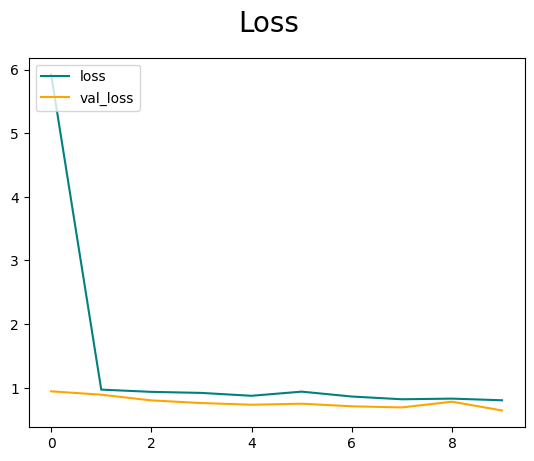

In [41]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

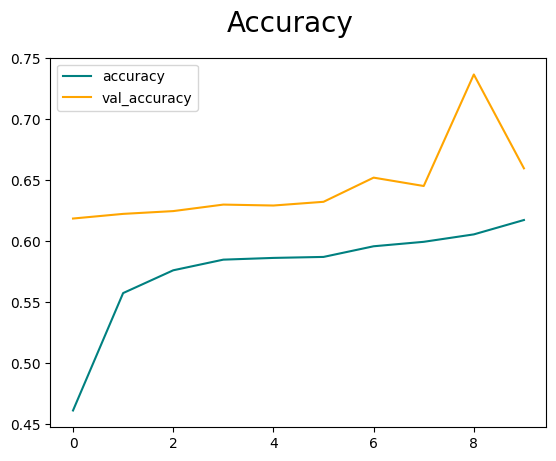

In [42]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [43]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [44]:
final_predictions = model.predict(testing_generator)

6/6 [==============================] - 14s 2s/step


In [45]:
true_labels = np.squeeze(testing_generator.classes)

In [46]:
binary_preds = np.argmax(final_predictions, axis=1)

In [47]:
pre.update_state(true_labels, binary_preds)
re.update_state(true_labels, binary_preds)
acc.update_state(true_labels, binary_preds)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=330.0>

In [48]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.7471697926521301, Recall: 0.7919999957084656, Accuracy: 0.25757575035095215


Точность не улучшилась

In [49]:
# Path to the image you want to predict
image_path0 = '/content/gdrive/MyDrive/Colab Notebooks/dataset/Tomato_YellowLeaf_Curl_Virus/16cdaa11-8d94-43ff-9acc-14048ad8f77f___UF.GRC_YLCV_Lab 02178.JPG'
image_path1 = '/content/gdrive/MyDrive/Colab Notebooks/dataset/Tomato_healthy/45b3e6ad-f79c-4132-9bb5-9e9d26cbdfce___RS_HL 9908.JPG'
image_path2 = '/content/gdrive/MyDrive/Colab Notebooks/dataset/Tomato_Septoria_leaf_spot/3fc4d8fe-a68b-4d84-b987-be97052f0436___Matt.S_CG 6570.JPG'

1/1 [==============================] - 2s 2s/step


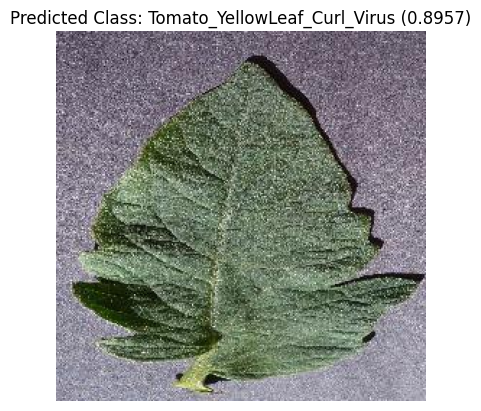

In [50]:
loaded_image = image_path1

# Load and preprocess the image
input_image = load_and_preprocess_image(loaded_image)

# Make a prediction
predictions = model.predict(input_image)

# Decode the predictions
predicted_class_index = np.argmax(predictions)
predicted_class_label = DATA_CLASSES[predicted_class_index]
predicted_probability = predictions[0][predicted_class_index]

# Display the image
img = mpimg.imread(loaded_image)
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted Class: {predicted_class_label} ({predicted_probability:.4f})')
plt.show()

В целом модели показали себя не очень хорошо, скорее всего их-за неравномерности данных.